# Evaluation metrics

## Model training

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression



In [3]:
df = pd.read_csv('data-week-3.csv')

In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

tc = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)
df.churn = (df.churn == 'yes').astype(int)

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [6]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']
categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]


In [7]:
dv = DictVectorizer(sparse=False)

train_dicts=df_train[categorical+numerical].to_dict(orient='records')
X_train = dv.fit(train_dicts).transform(train_dicts)

val_dicts = df_val[categorical+numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)


In [8]:
model = LogisticRegression()
model.fit(X_train,y_train)

y_pred = model.predict_proba(X_val)[:,1]
y_pred

/home/updog/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0.00901198, 0.20409738, 0.21175836, ..., 0.13652276, 0.80001517,
       0.837606  ])

In [9]:
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## Evaluation

In [10]:
from sklearn.metrics import accuracy_score

In [11]:
thresholds = np.linspace(0,1,21)

scores = []

for t in thresholds :
    churn_decision = (y_pred >= t)
    score = accuracy_score(y_val,churn_decision)
    print(f"{t:.2f} {score:.3f}")
    scores.append(score)


0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


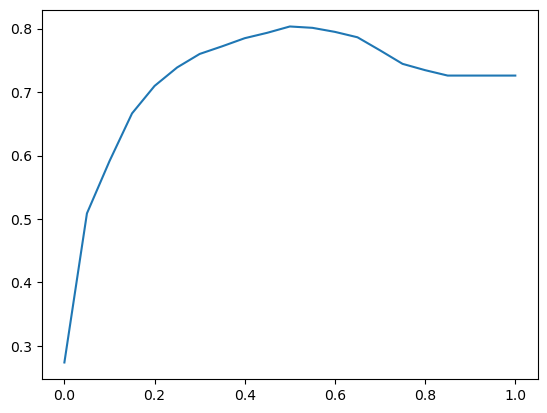

In [12]:
plt.plot(thresholds,scores)

In [13]:
1-df.churn.mean()

0.7346301292063041

In [14]:
1-df_full_train.churn.mean()

0.7300319488817891

## Confusion table

In [15]:
actual_positive = (y_val == 1)
actual_negatif = (y_val == 0)

t = 0.5

predicted_postif = (y_pred >= t)
predicted_negatif = (y_pred <= t)

In [16]:
tp = actual_positive & predicted_postif
tn = actual_negatif & predicted_negatif
fp = actual_negatif & predicted_postif
fn = actual_positive & predicted_negatif

In [17]:
print(f"Sum of True positifs : {tp.sum()}\nSum of True Negatives : {tn.sum()}\nSum of False Positives : {fp.sum()}\nSUm of Flase Negatives : {fn.sum()}")
print(f"Sum of all : {len(y_val)}")

Sum of True positifs : 210
Sum of True Negatives : 922
Sum of False Positives : 101
SUm of Flase Negatives : 176
Sum of all : 1409


In [18]:
confusion_matrix = np.array([
    [tn.sum(),fp.sum()],
    [fn.sum(),tp.sum()]
])
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

In [19]:
tn = tn.sum()
tp = tp.sum()
fp = fp.sum()
fn = fn.sum()

## Precision and recall

In [20]:
acc = (tn+tp) / (tn+tp+fn+fp)
acc

0.8034066713981547

### Accuracy

In [21]:
precision = tp / (tp+fp)
precision

0.6752411575562701

In [22]:
1 - precision

0.3247588424437299

### Recall

In [23]:
recall = tp / (tp + fn)
recall

0.5440414507772021

In [24]:
1 - recall

0.4559585492227979

## ROC Curves

### False positves rate

In [25]:
fpr = fp / (fp  + tn)
fpr

0.09872922776148582

### True positives rate

In [26]:
tpr = tp/(tp+fn)
tpr

0.5440414507772021

In [27]:
def tpr_fpr_df(y_val,y_pred):   
    thresholds = np.linspace(0,1,101)

    scores = []

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negatif = (y_val == 0)

        predicted_postif = (y_pred >= t)
        predicted_negatif = (y_pred <= t)

        tp = (actual_positive & predicted_postif).sum()
        tn = (actual_negatif & predicted_negatif).sum()
        fp = (actual_negatif & predicted_postif).sum()
        fn = (actual_positive & predicted_negatif).sum()

        scores.append((t,tp,fp,fn,tn))
    columns = ["thresholds","tp","fp","fn","tn"]
    df_scores =pd.DataFrame(scores,columns=columns)
    df_scores['fpr'] =  df_scores.fp / (df_scores.fp  + df_scores.tn)
    df_scores['tpr'] = df_scores.tp/(df_scores.tp+df_scores.fn)
    return df_scores

In [28]:
df_scores = tpr_fpr_df(y_val,y_pred)

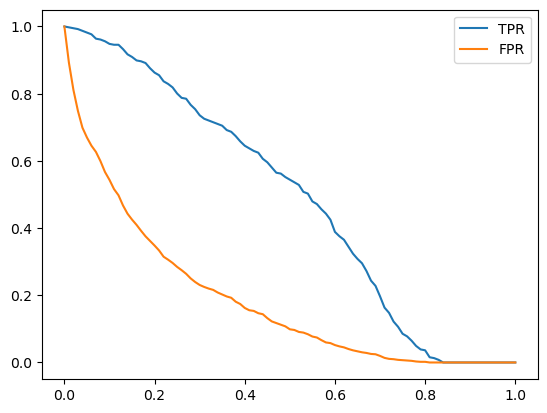

In [29]:
plt.plot(df_scores.thresholds,df_scores['tpr'],label='TPR')
plt.plot(df_scores.thresholds,df_scores['fpr'],label='FPR')
plt.legend()

### Random model 

In [30]:
np.random.seed(1)
y_rand = np.random.uniform(0,1,size= len(y_val))

In [31]:
((y_rand >= 0.5 )== y_val).mean()

0.5017743080198722

In [32]:
df_random = tpr_fpr_df(y_val,y_rand)

In [33]:
df_scores

,thresholds,tp,fp,fn,tn,fpr,tpr
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,385,913,1,110,0.892473,0.997409
2,0.02,384,830,2,193,0.811339,0.994819
3,0.03,383,766,3,257,0.748778,0.992228
4,0.04,381,715,5,308,0.698925,0.987047
...,...,...,...,...,...,...,...
96,0.96,0,0,386,1023,0.000000,0.000000
97,0.97,0,0,386,1023,0.000000,0.000000
98,0.98,0,0,386,1023,0.000000,0.000000
99,0.99,0,0,386,1023,0.000000,0.000000


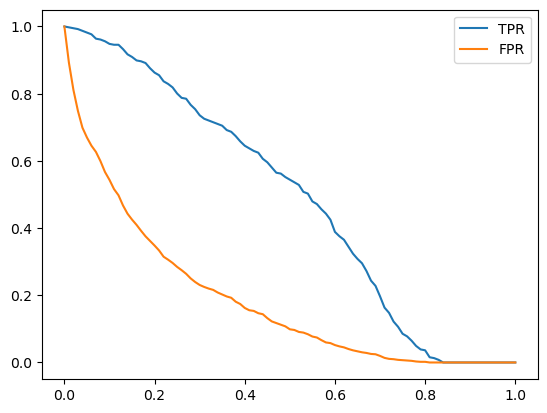

In [34]:
plt.plot(df_scores.thresholds,df_scores['tpr'],label='TPR')
plt.plot(df_scores.thresholds,df_scores['fpr'],label='FPR')
plt.legend()

### Ideal model

In [35]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg,num_pos

(1023, 386)

In [36]:
y_ideal = np.repeat([0,1],[num_neg,num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [37]:
y_ideal_pred = np.linspace(0,1,len(y_val))
y_ideal_pred

array([0.00000000e+00, 7.10227273e-04, 1.42045455e-03, ...,
       9.98579545e-01, 9.99289773e-01, 1.00000000e+00])

In [38]:
1 - num_pos/ (num_neg + num_pos) 

0.7260468417317246

In [39]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

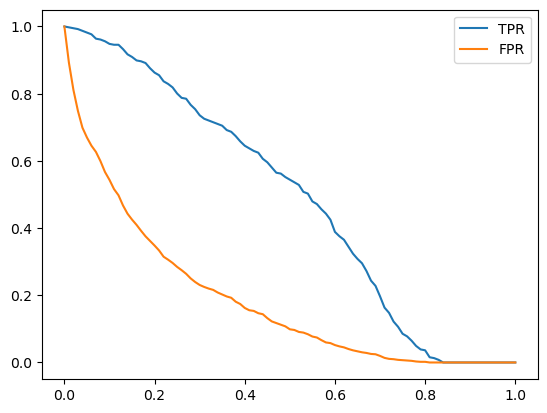

In [40]:
df_ideal = tpr_fpr_df(y_ideal,y_ideal_pred)
plt.plot(df_scores.thresholds,df_scores['tpr'],label='TPR')
plt.plot(df_scores.thresholds,df_scores['fpr'],label='FPR')
plt.legend()

### Everything

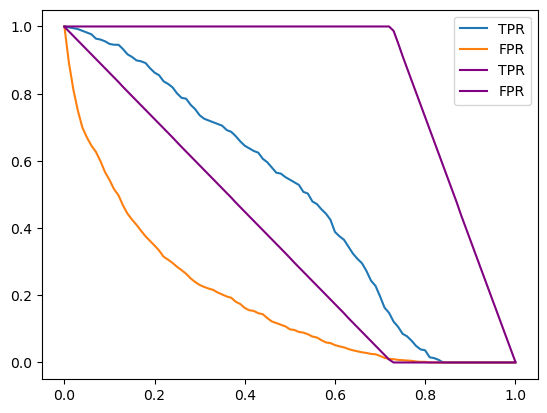

In [41]:
plt.plot(df_scores.thresholds,df_scores['tpr'],label='TPR')
plt.plot(df_scores.thresholds,df_scores['fpr'],label='FPR')

plt.plot(df_ideal.thresholds,df_ideal['tpr'],label='TPR',color ='purple')
plt.plot(df_ideal.thresholds,df_ideal['fpr'],label='FPR',color ='purple')

plt.legend()

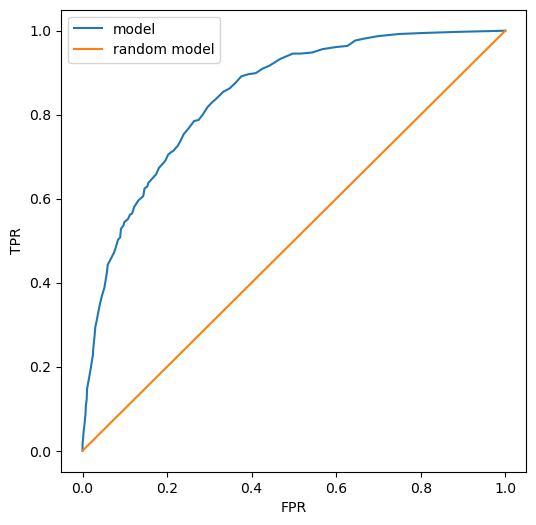

In [42]:
plt.figure(figsize=(6,6))

plt.plot(df_scores.fpr,df_scores.tpr,label='model')
plt.plot([0,1],[0,1],label='random model')


plt.xlabel("FPR")
plt.ylabel("TPR")

plt.legend()
plt.show()

In [43]:
from sklearn.metrics import roc_curve

fpr,tpr,thresholds = roc_curve(y_val,y_pred)


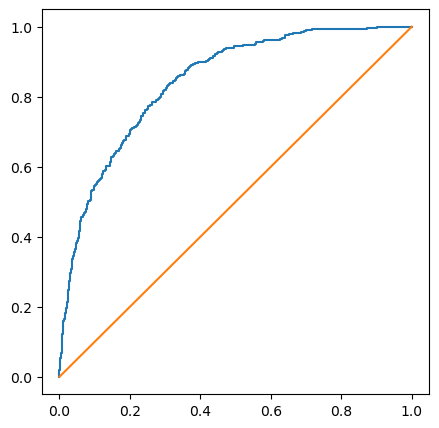

In [44]:
plt.figure(figsize=(5,5))

plt.plot(fpr,tpr,label='model')
plt.plot([0,1],[0,1],label = 'Random')

## ROC AUC

+ As the area under the curves increases the model is better.
+ 0.5 <= AUC <= 1.0

In [45]:
from sklearn.metrics import auc



In [46]:
auc(fpr,tpr)

0.8438505057258192

In [47]:
auc(df_scores.fpr,df_scores.tpr)

0.8438429084426075

In [48]:
auc(df_ideal.fpr,df_ideal.tpr)

0.9989664578759136

In [49]:
fpr,tpr,thresholds = roc_curve(y_val,y_pred)
auc(fpr,tpr)

0.8438505057258192

Combine auc and roc function

In [50]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val,y_pred)

0.8438505057258192

In [51]:
import random 

#### Interpretation

auc = probability(p(randomly selected positive) > p(randomly selected negative))

In [52]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val==1]

In [53]:
len(pos),len(neg)

(386, 1023)

In [54]:
n = 10000000
success = 0

for i in range(n):
    pos_ind = random.randint(0,len(pos)-1)
    neg_ind = random.randint(0,len(neg)-1)
    
    if pos[pos_ind] > neg[neg_ind]:
        success += 1
print(success / n)

0.8438178


In [55]:
n = 100000000
pos_ind = np.random.randint(0,len(pos),size=n)
neg_ind = np.random.randint(0,len(neg),size=n)

In [56]:
(pos[pos_ind] > neg[neg_ind]).mean() 

0.84391249

## Cross validation